In [24]:
import numpy as np
from math import sqrt
from sklearn import datasets, linear_model, metrics
from pprint import pprint
from sklearn.metrics import make_scorer, r2_score
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate, train_test_split, KFold
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectPercentile, f_regression
import matplotlib.pyplot as plt
from termcolor import colored
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Carga de datos.
dataset = datasets.load_boston()
X = dataset.data
y = dataset.target
print(np.shape(X))

(506, 13)


In [3]:
# Métricas de evaluación.
metricas = {'MAE':  'neg_mean_absolute_error',
            'RMSE': make_scorer(lambda y, y_pred:
                      sqrt(metrics.mean_squared_error(y, y_pred)),
                      greater_is_better=False),
            'MAPE': make_scorer(lambda y, y_pred:
                      np.mean(np.abs((y - y_pred) / y)) * 100,
                      greater_is_better=False)}

### 1) PARTICIÓN EXTERNA DE DATOS

In [4]:
# 1) Partición de datos externa
X_training, X_testing, y_training, y_testing = train_test_split(X, y, test_size=0.2, random_state=42)
print(np.shape(X_training))
print(np.shape(X_testing))

(404, 13)
(102, 13)


### 2-5) ENTRENAMIENTO

In [ ]:
# 2) Extracción de características

In [5]:
# 3) Estandarización de los datos de entrenamiento
standardizer = preprocessing.StandardScaler()
X_stdr = standardizer.fit_transform(X_training)

In [ ]:
# 4) Selección de atributos

In [6]:
# 5) Construcción del algoritmo de aprendizaje.
k = 10
reg = KNeighborsRegressor(n_neighbors = k, weights='distance', metric='euclidean')

In [7]:
# 5.1) Validación cruzada interna
# Extraer MEAN +- STD del coeficiente de determinación (R2) para un cross validation de 5 bolsas aleatorias y semilla en 42
r2_cv_results = cross_val_score(reg, X_stdr, y_training, cv = KFold(n_splits=5, shuffle=True, random_state=42))
print("cross_val_R2:   %0.4f +/- %0.4f" % (r2_cv_results.mean(), r2_cv_results.std()))

cross_val_R2:   0.7216 +/- 0.1121


In [8]:
# Extraer métricas MAE, MSE, RMSE y MAPE en un cross validation para 5 bolsas aleatorias y semilla en 42
metrics_cv_results = cross_validate(reg, X_stdr, y_training, cv = KFold(n_splits=5, shuffle=True, random_state=42), scoring=metricas)
pprint(metrics_cv_results)

{'fit_time': array([0.00099754, 0.0009973 , 0.0007751 , 0.        , 0.        ]),
 'score_time': array([0.0009973 , 0.00102639, 0.        , 0.        , 0.0048418 ]),
 'test_MAE': array([-3.42033374, -3.22759563, -3.38851836, -3.10542235, -2.31204307]),
 'test_MAPE': array([-16.07369641, -13.76638608, -14.16884202, -14.24046968,
       -11.71729274]),
 'test_RMSE': array([-5.36563305, -4.81169947, -6.09877868, -4.36938374, -3.19815593])}


In [9]:
# Extraer las predicciones del cross validation de 5 bolsas aleatorias y semilla en 42
y_pred = cross_val_predict(reg, X_stdr, y_training, cv = KFold(n_splits=5, shuffle=True, random_state=42))

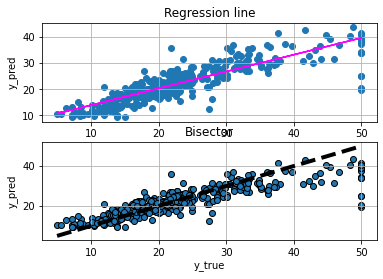

In [12]:
# Crear una función que dadas las variables "y" e "y_pred" se visualice la bisectriz y la recta de regresión
def report_regression_graphics(y_true, y_pred):
    fig, ax = plt.subplots(2,1)

    # Plot linear fit
    ax[0].scatter(y_true, y_pred)
    ax[0].set_ylabel('y_pred')
    ax[0].set_title('Regression line')
    ax[0].grid()
    # overlay the regression line
    z = np.polyfit(np.float64(y_true), y_pred, 1)
    p = np.poly1d(z)
    ax[0].plot(y_true, p(y_true), color='magenta')

    # Plot bisectriz
    ax[1].scatter(y_true, y_pred, edgecolors=(0, 0, 0))
    ax[1].set_xlabel('y_true')
    ax[1].set_ylabel('y_pred')
    ax[1].set_title('Bisector')
    ax[1].plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', lw=4)
    ax[1].grid()

# Visualiza la bisetriz y recta de regresión
report_regression_graphics(y_training, y_pred)

In [13]:
# 5.2) Entrenamiento del modelo definitivo
model = reg.fit(X_stdr, y_training)

### 6-10) PREDICCIÓN

In [ ]:
# 6) Extracción de las características de test 

In [14]:
# 7) Estandarización de las característiacs de test
X_test_stdr = standardizer.transform(X_testing)

In [ ]:
# 8) Selección de los atributos de test

In [15]:
# 9) Predicción del conjunto de test
y_pred_test = model.predict(X_test_stdr)

MAE:  2.6974
MSE: 22.6257
RMSE: 4.7566
R2:   0.6915


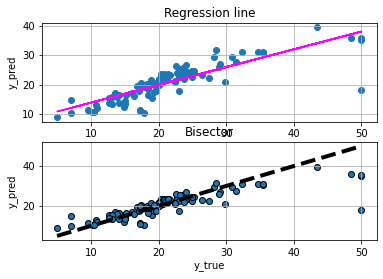

In [16]:
### 10) Evaluación del modelo sobre el conjunto de test
MAE = metrics.mean_absolute_error(y_testing, y_pred_test)
MSE = metrics.mean_squared_error(y_testing, y_pred_test, squared=True)
RMSE = metrics.mean_squared_error(y_testing, y_pred_test, squared=False)
R2 = metrics.r2_score(y_testing, y_pred_test)

print('MAE:  %.4f' % MAE)
print('MSE: %.4f' % MSE)
print('RMSE: %.4f' % RMSE)
print('R2:   %.4f' % R2)

# Visualización de resultados
report_regression_graphics(y_testing, y_pred_test)

### ACTIVIDAD EXTRA

#### Entrenar el mejor modelo posible con el algoritmo KNN y comparar el resultado con el modelo OLS en test

In [17]:
from sklearn.model_selection import GridSearchCV
# Definir parámetros de búsqueda
parameters = {'n_neighbors':range(10), 
              'weights':('uniform', 'distance'), 
              'metric': ('minkowski', 'euclidean', 'manhattan'), 
              'algorithm': ('ball_tree', 'kd_tree', 'auto')}

# Aplicar el algoritmo de búsqueda
reg = KNeighborsRegressor()
model = GridSearchCV(reg, parameters, scoring='r2')

# Entrenar el modelo
model.fit(X_stdr, y_training)

# Extraer los mejores parámetros
model.best_params_

{'algorithm': 'ball_tree',
 'metric': 'minkowski',
 'n_neighbors': 2,
 'weights': 'distance'}

In [18]:
# OPTIMIZATION OF HYPERPARAMETERS
parameters = {'OLS': {'normalize': (True, False)},
              'Lasso': {'alpha': (0.1, 1, 5, 10, 50, 100)},
              'Ridge': {'alpha': (0.1, 1, 5, 10, 50, 100)},
              'KNN': {'n_neighbors':range(10),
                      'weights':('uniform', 'distance'),
                      'metric': ('minkowski', 'euclidean', 'manhattan'),
                      'algorithm': ('ball_tree', 'kd_tree', 'auto')}}

In [20]:
# ALGORITHMS
algs = {'OLS': linear_model.LinearRegression(),
        'Lasso': linear_model.Lasso(random_state=42),
        'Ridge': linear_model.Ridge(random_state=42),
        'KNN': KNeighborsRegressor()}


In [26]:
model = {}
for name, _ in algs.items():
    print(colored('Algorithm: ' + name, 'red'))
    score = make_scorer(r2_score)
    model_cv = GridSearchCV(algs[name], parameters[name], scoring=score, cv=5, return_train_score=True)
    model[name] = model_cv.fit(X_stdr, y_training)
    cv_res = model[name].cv_results_
    print('Best parameters: ', model[name].best_params_)
    best_iter = model[name].best_index_
    print('R2 score: %0.4f +/- %0.4f' % (cv_res['mean_test_score'][best_iter], cv_res['std_test_score'][best_iter]))
    print('------------')

Algorithm: OLS
Best parameters:  {'normalize': True}
R2 score: 0.7244 +/- 0.0635
------------
Algorithm: Lasso
Best parameters:  {'alpha': 0.1}
R2 score: 0.7180 +/- 0.0640
------------
Algorithm: Ridge
Best parameters:  {'alpha': 5}
R2 score: 0.7245 +/- 0.0633
------------
Algorithm: KNN
Best parameters:  {'algorithm': 'ball_tree', 'metric': 'minkowski', 'n_neighbors': 2, 'weights': 'distance'}
R2 score: 0.8223 +/- 0.0397
------------
